# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem

Manhattan, the most densely populated borough of the New York City, is a well-known area which serves as the economic and administrative center of the United States. It covers 33.58 square miles’ land and has approximately 1,628,706 residents (by 2019) in total. People all around the world are attracted to Manhattan because of its leading economy, diverse culture, historical tourism and, more importantly, huge potential for success. Therefore, it is advantageous for us to explore deeper into Manhattan in terms of business opportunities. 

There are lots of coffee shops locating in different neighborhoods of Manhattan. Their business performances highly depend on various factors including location, residence and other business categories. Therefore, based on these considerations, this project aims to **find the optimal neighborhood for opening a coffee shop/café**. Specifically, we will explore 40 neighborhoods in Manhattan and generate a best solution for stakeholders interested in coffee business. 

## Data

We will be using three types of data in this project: Manhattan neighborhood data, Manhattan population data and Foursquare location data.

**Manhattan Neighborhood Data**
Manhattan neighborhood data can be found in IBM Skills Network. The data is in JSON format containing features including boroughs, neighborhoods, latitude and longitude across all 5 boroughs in the New York City. The dataset has 306 neighborhoods in total along with their coordinates. We will only use borough Manhattan data from this data set.

**Manhattan Population Data**
Manhattan population data can be scraped from the Neighborhoods in New York City page of Wikipedia. It contains area, population and population density for each community board which is the appointed advisory group of the community districts of Manhattan. Manhattan has 12 community boards (CB) in total. Based on this dataset, we can see which neighborhoods are assigned to the same community board and the population distribution across all community areas.

**Foursquare Location Data**
We will also use the Foursquare API to pull the venue information based on each Manhattan neighborhood’s coordinates and to explore what kinds of venue categories are in the neighborhood and their frequencies. We will also pay closer attention to coffee related categories specifically. According to the Foursquare documentation, venue categories related with coffee are named to Coffee Shop, Cafeteria, or Café. Therefore, when we explore coffee business in Manhattan, we will extract those venue data based on the three category names.

## Methodology

To find a neighborhood that is the best to open a café, we will need to consider the following factors:
* The number of coffee shops already existing in the neighborhood
* The number of different venue categories in the neighborhood
* Population of the neighborhood

Specifically, we do not want to open our café in the place where there already are many coffee shops around as this may significantly increase our business competition/burden. We also want to look at the number of venue categories because this information can represent business variety in the neighborhood. The more venue categories the neighborhood has, the more diverse the environment can be, and the more potential the business can explore. Besides, we also consider population of the neighborhood as we want to find a neighborhood with more residence which may lead to more attention and popularity. 

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from statistics import mean
import matplotlib.pyplot as plt
print('Libraries imported.')

Libraries imported.


### Manhattan neighborhoods data

Download the New York City data, and then load and explore.

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's transform the data into a pandas dataframe with columns Borough, Neighborhood, Latitude and Longitude.

In [5]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


New York City has 5 boroughs and 306 neighborhoods in total. In this project, as we only want to explore the business opportunity in Borough Manhattan, we need to filter the data to get the Manhanttan data with its neighborhoods and locations.

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
print('We are looking at the Manhattan borough with Neighborhoods {}. '.format(', '.join(manhattan_data['Neighborhood'].unique())))

We are looking at the Manhattan borough with Neighborhoods Marble Hill, Chinatown, Washington Heights, Inwood, Hamilton Heights, Manhattanville, Central Harlem, East Harlem, Upper East Side, Yorkville, Lenox Hill, Roosevelt Island, Upper West Side, Lincoln Square, Clinton, Midtown, Murray Hill, Chelsea, Greenwich Village, East Village, Lower East Side, Tribeca, Little Italy, Soho, West Village, Manhattan Valley, Morningside Heights, Gramercy, Battery Park City, Financial District, Carnegie Hill, Noho, Civic Center, Midtown South, Sutton Place, Turtle Bay, Tudor City, Stuyvesant Town, Flatiron, Hudson Yards. 


In [8]:
manhattan_data.shape

(40, 4)

### Manhattan population data

We download the manhattan population data from Wikipedia. It contains population for each community board that is the appointed advisory group of the community districts of Manhattan. Manhattan has 12 community boards (CB) in total.

In [9]:
population_data = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City#Boroughs')[0]
# filter Manhattan CB data
population_data = population_data[population_data['Community Board(CB)'].str.contains('Manhattan')].reset_index(drop=True)

In [10]:
population_data.columns = ['CB', 'Area', 'Population', 'Population/Area', 'Neighborhoods']
population_data.head()

,CB,Area,Population,Population/Area,Neighborhoods
0,Manhattan CB 1,4.45,34420,7735,"Battery Park City, Financial District, Tribeca"
1,Manhattan CB 2,4.01,93119,23222,"Chinatown, Greenwich Village, Little Italy, Lo..."
2,Manhattan CB 3,4.56,164407,36054,"Alphabet City, Chinatown, East Village, Lower ..."
3,Manhattan CB 4,5.41,87479,16170,"Chelsea, Clinton, Hell's Kitchen, Hudson Yards"
4,Manhattan CB 5,4.25,44028,10360,Midtown


We should create a function to find the latitude and longitude for each community board and merge it with the population dataframe.

In [11]:
def find_CB_lat_long(row):
    neighborhoods = row['Neighborhoods'].split(', ')
    lat_list = []
    long_list = []
    for neigh in neighborhoods:
        address = neigh + ', Manhattan, NY'
        geolocator = Nominatim(user_agent="manhattan_explorer")
        location = geolocator.geocode(address)
        lat_list.append(location.latitude)
        long_list.append(location.longitude)
    return [row['Neighborhoods'], mean(lat_list), mean(long_list)]              

In [12]:
CB_data_full = []
population_data.apply(lambda x: CB_data_full.append(find_CB_lat_long(x)), axis = 1)
CB_lat_long = pd.DataFrame(CB_data_full, columns=['Neighborhoods', 'Latitude', 'Longitude'])
population_full = population_data.merge(CB_lat_long, on = 'Neighborhoods')
population_full

,CB,Area,Population,Population/Area,Neighborhoods,Latitude,Longitude
0,Manhattan CB 1,4.45,34420,7735,"Battery Park City, Financial District, Tribeca",40.711336,-74.011874
1,Manhattan CB 2,4.01,93119,23222,"Chinatown, Greenwich Village, Little Italy, Lo...",40.723803,-73.996589
2,Manhattan CB 3,4.56,164407,36054,"Alphabet City, Chinatown, East Village, Lower ...",40.719617,-73.988447
3,Manhattan CB 4,5.41,87479,16170,"Chelsea, Clinton, Hell's Kitchen, Hudson Yards",40.742572,-74.002801
4,Manhattan CB 5,4.25,44028,10360,Midtown,40.760109,-73.978163
5,Manhattan CB 6,3.55,136152,38353,"Gramercy Park, Kips Bay, Rose Hill, Murray Hil...",40.743383,-73.975280
6,Manhattan CB 7,5.46,207699,38040,"Lincoln Square, Manhattan Valley, Upper West Side",40.786380,-73.975863
7,Manhattan CB 8,5.13,217063,42312,"Lenox Hill, Roosevelt Island, Upper East Side,...",40.769891,-73.955392
8,Manhattan CB 9,3.91,111724,28574,"Hamilton Heights, Manhattanville, Morningside ...",40.816641,-73.954705
9,Manhattan CB 10,3.63,107109,29507,"Harlem, Polo Grounds",40.798751,-73.952655


### Foursquare Location data

Now we have the neighborhoods and population data for Manhattan. The next step is to use the Foursquare API to pull the venue info for each neighborhood. We want to see what kinds of venue categories in the neighborhood and their popularities. We will also need to pay closer attention to coffee/cafe related categories specifically.

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):  
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)           
        # make the GET request
        if requests.get(url).json()["response"]:
            results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

In [15]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood.

In [16]:
manhattan_venues.rename(columns={'Venue Category': 'Category'}, inplace=True)

In [17]:
print('There are {} unique venues categories.'.format(len(manhattan_venues['Category'].unique())))

There are 331 unique venues categories.


We will then explore each neighborhood to see its top categories.

In [18]:
coffee_categories = ['Coffee Shop', 'Cafeteria', 'Café']
manhattan_venues['Category'] = ['Cafe' if x in coffee_categories else x for x in manhattan_venues['Category']]
venues_with_coffee = manhattan_venues[manhattan_venues['Category']=='Cafe']
coffee_df = pd.DataFrame(venues_with_coffee.groupby(['Neighborhood']).Category.value_counts(sort=True))
coffee_df.columns=['Counts']
coffee_df.index = coffee_df.index.get_level_values('Neighborhood')
coffee_df.sort_values(by='Counts', inplace=True, ascending=False)
coffee_df.head()

,Counts
Neighborhood,
Financial District,13
Carnegie Hill,13
Chelsea,10
Civic Center,9
Hamilton Heights,8


In [19]:
coffee_df.tail()

,Counts
Neighborhood,
Central Harlem,2
Marble Hill,2
Stuyvesant Town,2
East Harlem,1
Roosevelt Island,1


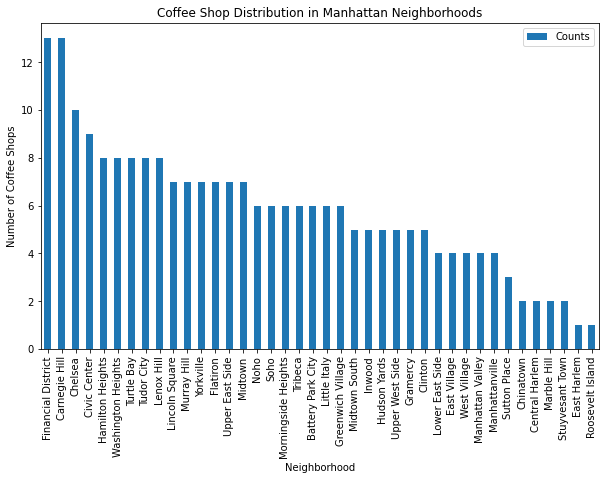

In [20]:
coffee_df.plot(kind='bar', figsize=(10, 6), rot=90)
plt.xlabel('Neighborhood')
plt.ylabel('Number of Coffee Shops')
plt.title('Coffee Shop Distribution in Manhattan Neighborhoods')
plt.show()

Based on the bar plot, we can see that Financial District and Carnegie Hill are the two neighborhoods with the most number of coffee shops. East Harlem and Roosevelt Island are the two with only one coffee shop in their neighborhoods. We want to pick the neighborhoods that are best for the business opportunities. So we should avoid those neighborhoods that already have many coffee shops. We should also take other venues into consideration. So we will step closer to those neighborhoods in the middle of the bar plot.

Below are the neighborhoods with the amount of coffee shops equal to 6. They can be treated as our candidates in terms of cafe business location.

In [60]:
candidates = coffee_df[coffee_df['Counts']==6].index.tolist()

In [61]:
# The code was removed by Watson Studio for sharing.

In [62]:
candidates

['Noho',
 'Soho',
 'Morningside Heights',
 'Tribeca',
 'Battery Park City',
 'Little Italy',
 'Greenwich Village',
 'Murray Hill']

In [44]:
manhattan_venues.groupby('Neighborhood').count().loc[candidates]

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
Neighborhood,,,,,,
Noho,100,100,100,100,100,100
Soho,100,100,100,100,100,100
Morningside Heights,43,43,43,43,43,43
Tribeca,84,84,84,84,84,84
Battery Park City,77,77,77,77,77,77
Little Italy,100,100,100,100,100,100
Greenwich Village,100,100,100,100,100,100
Murray Hill,100,100,100,100,100,100


As the above dataframe shows, Morningside Heights has the least number of venue categories. We should remove it from consideration because of its limited venues. The larger the number of venue categories, the more popular the neighborhood is, and the more popential it will be. So we will then keep exploring the left 8 neighborhoods of Manhattan.

In [45]:
candidates.remove('Morningside Heights')
candidates

['Noho',
 'Soho',
 'Tribeca',
 'Battery Park City',
 'Little Italy',
 'Greenwich Village',
 'Murray Hill']

In [46]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafe,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,So

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category based on the above onehot dataframe.

In [47]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafe,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,So

Let's examine the top 5 most common venues in our candidate neighborhoods of Manhattan.

In [48]:
num_top_venues = 5

for hood in candidates:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Noho----
                venue  freq
0                Cafe  0.06
1  Italian Restaurant  0.06
2        Cocktail Bar  0.04
3               Hotel  0.04
4         Yoga Studio  0.03


----Soho----
                 venue  freq
0       Clothing Store  0.08
1                 Cafe  0.06
2   Italian Restaurant  0.06
3  Sporting Goods Shop  0.03
4             Boutique  0.03


----Tribeca----
                 venue  freq
0                 Cafe  0.07
1   Italian Restaurant  0.06
2                 Park  0.06
3  American Restaurant  0.05
4                  Spa  0.05


----Battery Park City----
           venue  freq
0           Cafe  0.08
1          Hotel  0.06
2           Park  0.06
3            Gym  0.05
4  Memorial Site  0.04


----Little Italy----
                venue  freq
0                Cafe  0.06
1              Bakery  0.05
2  Italian Restaurant  0.04
3  Chinese Restaurant  0.04
4     Bubble Tea Shop  0.04


----Greenwich Village----
                venue  freq
0  Italian Restaurant  0.

Let's create a new data frame and display the top 10 venue categories in candidate neighborhoods.

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[neighborhoods_venues_sorted.apply(lambda x: x['Neighborhood'] in candidates, axis=1)]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Cafe,Park,Hotel,Gym,Memorial Site,Clothing Store,Pizza Place,Playground,Plaza,Gourmet Shop
12,Greenwich Village,Italian Restaurant,Cafe,Clothing Store,Sushi Restaurant,American Restaurant,Indian Restaurant,Dessert Shop,French Restaurant,Sandwich Place,Pilates Studio
18,Little Italy,Cafe,Bakery,Italian Restaurant,Chinese Restaurant,Bubble Tea Shop,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Sandwich Place,Mediterranean Restaurant
26,Murray Hill,Cafe,Hotel,Sandwich Place,Bar,American Restaurant,Gym / Fitness Center,Burger Joint,Japanese Restaurant,Italian Restaurant,Bakery
27,Noho,Italian Restaurant,Cafe,Cocktail Bar,Hotel,Pizza Place,Bookstore,Sandwich Place,Yoga Studio,Mexican Restaurant,Grocery Store
29,Soho,Clothing Store,Cafe,Italian Restaurant,Asian Restaurant,Sporting Goods Shop,Bakery,Boutique,Salon / Barbershop,Mediterranean Restaurant,Dessert Shop
32,Tribeca,Cafe,Park,Italian Restaurant,Spa,American Restaurant,Men's Store,Greek Restaurant,Wine Bar,Playground,Skate Park


### Cluster neighborhoods in Manhattan

At this step, we will cluster the neighborhoods of Manhattan into k clusters. We will first use the elbow method to find the optimal K value, and then implement k-means clustering.

For n_clusters = 4 The average silhouette_score is : 0.0406553600855037
For n_clusters = 5 The average silhouette_score is : 0.01997988537617324
For n_clusters = 6 The average silhouette_score is : 0.022706624627958704
For n_clusters = 7 The average silhouette_score is : 0.00844134435111136
For n_clusters = 8 The average silhouette_score is : 0.014742151225342892
For n_clusters = 9 The average silhouette_score is : 0.010659975192796049


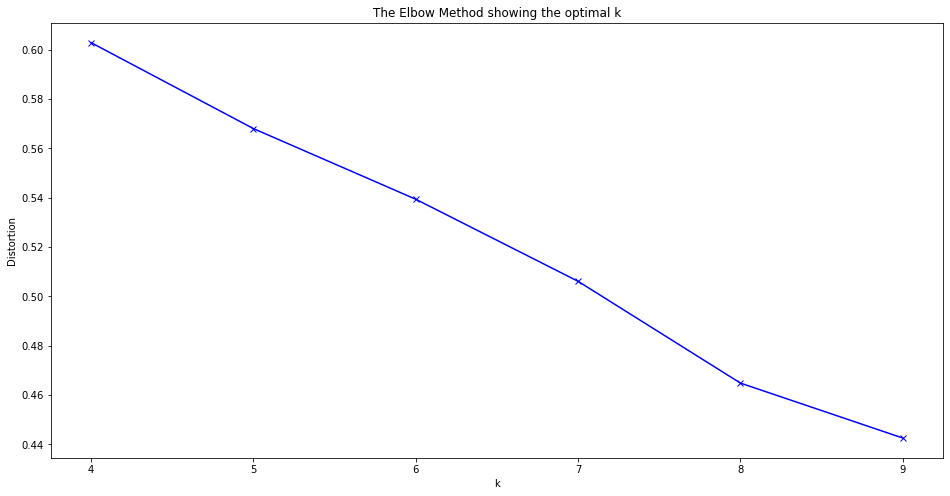

In [50]:
# set number of clusters
k_range = range(4, 10)
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
distortions = []
for k in k_range:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans.fit(manhattan_grouped_clustering)
    distortions.append(kmeans_model.inertia_)
    cluster_labels = kmeans.fit_predict(manhattan_grouped_clustering)
    # The silhouette_score gives the average value for all the samples. 
    silhouette_avg = silhouette_score(manhattan_grouped_clustering, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
# the elbow plot
plt.figure(figsize=(16,8))
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method plot overall does not show significant kink for k from 4 to 9, but it has a very small kink around k=7. We also use Silhouette Score as another metric to determine the optimal k. Silhouette score gives a perspective into the density and separation of the formed clusters as it measures how similar a point is to its own cluster compared to other clusters. According to the output, k=6 and k=7 give the maximum silhouette scores. Therefore, we choose to run k-means with 7 clusters.

In [51]:
# set number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = manhattan_data
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
# select rows for our candidate neighborhoods
candidate_merged = manhattan_merged[manhattan_merged.apply(lambda x: x['Neighborhood'] in candidates, axis=1)]
candidate_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Manhattan,Murray Hill,40.748303,-73.978332,1,Cafe,Hotel,Sandwich Place,Bar,American Restaurant,Gym / Fitness Center,Burger Joint,Japanese Restaurant,Italian Restaurant,Bakery
18,Manhattan,Greenwich Village,40.726933,-73.999914,0,Italian Restaurant,Cafe,Clothing Store,Sushi Restaurant,American Restaurant,Indian Restaurant,Dessert Shop,French Restaurant,Sandwich Place,Pilates Studio
21,Manhattan,Tribeca,40.721522,-74.010683,1,Cafe,Park,Italian Restaurant,Spa,American Restaurant,Men's Store,Greek Restaurant,Wine Bar,Playground,Skate Park
22,Manhattan,Little Italy,40.719324,-73.997305,0,Cafe,Bakery,Italian Restaurant,Chinese Restaurant,Bubble Tea Shop,Cocktail Bar,Salon / Barbershop,Ice Cream Shop,Sandwich Place,Mediterranean Restaurant
23,Manhattan,Soho,40.722184,-74.000657,0,Clothing Store,Cafe,Italian Restaurant,Asian Restaurant,Sporting Goods Shop,Bakery,Boutique,Salon / Barbershop,Mediterranean Restaurant,Dessert Shop
28,Manhattan,Battery Park City,40.711932,-74.016869,3,Cafe,Park,Hotel,Gym,Memorial Site,Clothing Store,Pizza Place,Playground,Plaza,Gourmet Shop
31,Manhattan,Noho,40.723259,-73.988434,1,Italian Restaurant,Cafe,Cocktail Bar,Hotel,Pizza Place,Bookstore,Sandwich Place,Yoga Studio,Mexican Restaurant,Grocery Store


Let's visualize the clustering output.

In [52]:
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [54]:
# create map
map_pop = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to the map
for lat, lon, cb, poi, pop in zip(population_full['Latitude'], population_full['Longitude'], population_full['CB'], population_full['Neighborhoods'], population_full['Population']):
    label = folium.Popup(' '.join(cb.split('\xa0')) + ': ' + str(poi), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=pop/150,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.7).add_to(map_pop)
       
map_pop

The folium plot shows the population density of each manhattan community board.

In [55]:
population_full.sort_values(by='Population', inplace=True, ascending=False)
population_full.reset_index(inplace=True, drop=True)
neighborhoods_with_most_pop = ', '.join(population_full.head()['Neighborhoods'])
neighborhoods_with_most_pop

'Lenox Hill, Roosevelt Island, Upper East Side, Yorkville, Inwood, Washington Heights, Lincoln Square, Manhattan Valley, Upper West Side, Alphabet City, Chinatown, East Village, Lower East Side, Two Bridges, Gramercy Park, Kips Bay, Rose Hill, Murray Hill, Peter Cooper Village, Stuyvesant Town, Sutton Place, Tudor City, Turtle Bay, Waterside Plaza'

In [56]:
len(neighborhoods_with_most_pop.split(', '))

24

In [57]:
population_full.head()

,CB,Area,Population,Population/Area,Neighborhoods,Latitude,Longitude
0,Manhattan CB 8,5.13,217063,42312,"Lenox Hill, Roosevelt Island, Upper East Side,...",40.769891,-73.955392
1,Manhattan CB 12,7.64,208414,27279,"Inwood, Washington Heights",40.854728,-73.930358
2,Manhattan CB 7,5.46,207699,38040,"Lincoln Square, Manhattan Valley, Upper West Side",40.786380,-73.975863
3,Manhattan CB 3,4.56,164407,36054,"Alphabet City, Chinatown, East Village, Lower ...",40.719617,-73.988447
4,Manhattan CB 6,3.55,136152,38353,"Gramercy Park, Kips Bay, Rose Hill, Murray Hil...",40.743383,-73.975280


In [58]:
for i in candidates:
    if i in neighborhoods_with_most_pop:
        print(i)

Murray Hill


Among our candidate neighborhoods, Murray Hill is the one that belongs to the community board with the most population. Therefore, as we believe that larger population indicates more business opportunities, Murray Hill can be the ideal neighborhood for our cafe business.

In [134]:
candidate_merged[candidate_merged['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Manhattan,Murray Hill,40.748303,-73.978332,1,Hotel,Cafe,Sandwich Place,Bar,American Restaurant,Italian Restaurant,Burger Joint,Japanese Restaurant,Gym / Fitness Center,Restaurant


If we look at the top 10 most common venues in Murray Hill, we can see that this neighborhood is very entertainment-oriented. Most of the venue categories are food. It also fullfills the requirement that there are not too many coffee shops existing already. Hence we can have much potential here in terms of revenue and popularity.

## Results and Discussion

We’ve followed **three factors** as our standard of choosing a neighborhood that is optimal to open a café/coffee shop. We started with 40 neighborhoods in Manhattan and narrowed down to 9 as candidates based on the existing coffee business in the neighborhoods. We then looked at the diversity of venue categories in the neighborhoods to determine business potential and space for development. In addition, we took population density into consideration as one of the factors to measure residence condition and future exposure. By investigating all **three factors**, we got a solution that out of all neighborhoods in Manhattan, Murray Hill is the optimal one to open our café/coffee shop. Therefore, we can recommend our stakeholders that **Murray Hill** can be the ideal neighborhood to open a café/coffee shop. 

However, there are some **improvements** that can be done in the future. We only analyzed the data for the Manhattan borough and performed a clustering algorithm to find those similar neighborhoods. One thing to note that the elbow method we implemented did not give us an explicit instruction of choosing the optimal k value, even though we saw a small kink around 7. Silhouette scores were not high enough to ensure us the best k as well. Therefore, we may need more information to run clustering, either more feature analysis or more metrics to compare. Besides, the result is based on the three factors we analyzed in this project. We should take additional factors into consideration such as housing price and the neighborhood center location, as they may influence the café business to some extent as well.

## Conclusion

The goal of our project is to help our stakeholders find the optimal neighborhood in Manhattan to open a café/coffee shop. According to the analysis of the three factors, we can conclude that Murray Hill is the one that fulfills all the requirements. It does not have many coffee shops in the neighborhood for now, so we do not need to care about the business competition with other owners. Murray Hill also has many unique venue categories in it, which indicates business diversity and huge potential for growth. Relatively larger population density is also another advantage of Murray Hill as it represents popularity and exposure. Therefore, Murray Hill is recommended for our stakeholders. This can be used as a reference, and final decision will be made by stakeholders who are interested in opening a café in Manhattan. They will need to consider additional factors and improvements that we discussed above. 